In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Loader.ReadCSV import Reader


In [2]:
data = Reader.read_file(timeframe="H1").dropna()[["Open","High","Low","Close"]]
data.head()

,Open,High,Low,Close
datetime,,,,
2023-05-01 00:00:00,1.10106,1.10143,1.10045,1.10055
2023-05-01 01:00:00,1.10055,1.10084,1.10020,1.10040
2023-05-01 02:00:00,1.10037,1.10081,1.10007,1.10081
2023-05-01 03:00:00,1.10081,1.10140,1.10053,1.10140
2023-05-01 04:00:00,1.10143,1.10143,1.10032,1.10062


In [33]:
from feature_engineering.pipelines.AlphaPlusPipeline import ap_pipeline_x_expanded
data_features = ap_pipeline_x_expanded.fit_transform(data).dropna()
data_features.head()

,Open,High,Low,Close,aws_5_34,kma_10_2_20,ppo_26_12_9,roc_12,rsi_14,srsi_14_3_4,srsi_14_3_4_d,srsi_14_3_4_k,bbh_50_2.0,bbl_50_2.0,bbh_15_1.5,bbl_15_1.5
datetime,,,,,,,,,,,,,,,,
2023-05-03 01:00:00,1.10173,1.10240,1.10128,1.10227,0.002543,1.100370,0.079393,0.724638,65.320631,1.000000,0.967294,1.000000,1.102948,1.095071,1.102602,1.096089
2023-05-03 02:00:00,1.10228,1.10258,1.10197,1.10253,0.002822,1.100759,0.089982,0.419885,66.244846,1.000000,0.988093,1.000000,1.103088,1.095011,1.103015,1.096445
2023-05-03 03:00:00,1.10252,1.10297,1.10251,1.10294,0.003132,1.101297,0.100217,0.299186,67.706396,1.000000,0.998436,1.000000,1.103267,1.094933,1.103246,1.097203
2023-05-03 04:00:00,1.10294,1.10294,1.10212,1.10216,0.003296,1.101392,0.101438,0.198185,62.189603,0.517817,0.959818,0.839272,1.103355,1.094899,1.102717,1.098775
2023-05-03 05:00:00,1.10217,1.10263,1.10182,1.10200,0.003334,1.101436,0.100076,0.207326,61.089996,0.421709,0.871445,0.646509,1.103396,1.094882,1.102678,1.099358


In [34]:
def df_to_X_y(df, window_size=5):
    df_as_np=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row=[a for a in df_as_np[i:i+window_size]]
        X.append(row)
        y.append(df_as_np[i+window_size][3])
    return np.array(X),np.array(y)
X,y=df_to_X_y(data_features,40)


In [35]:
X.shape

(3028, 40, 16)

In [36]:
def separate(X,y,pct_train=0.7,pct_val=0.1):
    pivot_train = int(len(X)*pct_train)
    pivot_val = int(len(X)*(pct_val+pct_train))
    X_train = X[:pivot_train]
    y_train = y[:pivot_train]
    X_val = X[pivot_train:pivot_val]
    y_val=y[pivot_train:pivot_val]
    X_test = X[pivot_val:]
    y_test=y[pivot_val:]
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = separate(X,y)


In [40]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from Models.transformer import transformer_model

cp = ModelCheckpoint('model_transformer_regression/',save_best_only=True)
input_shape = (X_train.shape[1], X_train.shape[2])
num_layers = 32
dff = 256
d_model = 16
num_heads = 16
dropout = 0.15
output_dim = 1
model = transformer_model(input_shape, num_layers, dff, d_model, num_heads, dropout, output_dim)

model.compile(optimizer=Adam(learning_rate=0.001),loss=MeanSquaredError(), metrics=RootMeanSquaredError())


In [41]:
history = model.fit(x=X_train,y=y_train,epochs=10,validation_data=(X_val,y_val),shuffle=False,callbacks=[cp])

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.8951 - root_mean_squared_error: 0.9461INFO:tensorflow:Assets written to: model_transformer_regression\assets


INFO:tensorflow:Assets written to: model_transformer_regression\assets


67/67 [==============================] - 194s 2s/step - loss: 0.8951 - root_mean_squared_error: 0.9461 - val_loss: 0.8772 - val_root_mean_squared_error: 0.9366
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.2713 - root_mean_squared_error: 0.5209INFO:tensorflow:Assets written to: model_transformer_regression\assets


INFO:tensorflow:Assets written to: model_transformer_regression\assets


67/67 [==============================] - 142s 2s/step - loss: 0.2713 - root_mean_squared_error: 0.5209 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1803
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.2270INFO:tensorflow:Assets written to: model_transformer_regression\assets


INFO:tensorflow:Assets written to: model_transformer_regression\assets


67/67 [==============================] - 166s 2s/step - loss: 0.0515 - root_mean_squared_error: 0.2270 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 4/10
67/67 [==============================] - 124s 2s/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 5/10
67/67 [==============================] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0748INFO:tensorflow:Assets written to: model_transformer_regression\assets


INFO:tensorflow:Assets written to: model_transformer_regression\assets


67/67 [==============================] - 151s 2s/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 6/10
67/67 [==============================] - 99s 1s/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0941
Epoch 7/10
67/67 [==============================] - 96s 1s/step - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 8/10
67/67 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0696INFO:tensorflow:Assets written to: model_transformer_regression\assets


INFO:tensorflow:Assets written to: model_transformer_regression\assets


67/67 [==============================] - 132s 2s/step - loss: 0.0049 - root_mean_squared_error: 0.0696 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 9/10
67/67 [==============================] - 88s 1s/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 10/10
67/67 [==============================] - 90s 1s/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797


Text(0.5, 1.0, 'Model fitting performance')

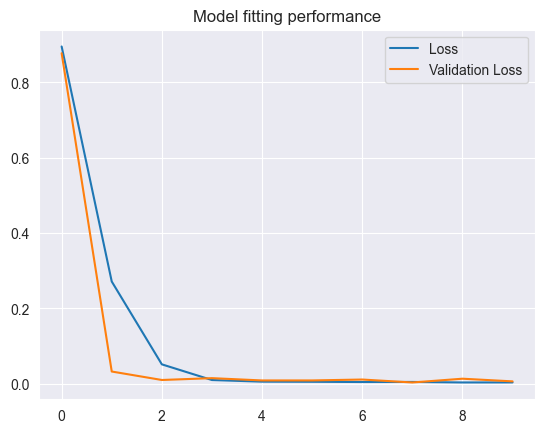

In [42]:
axes=plt.axes()
axes.plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')

In [43]:
model1=load_model('model_transformer_regression/')

67/67 [==============================] - 47s 598ms/step


Text(0.5, 1.0, 'Prediction adjustment Train')

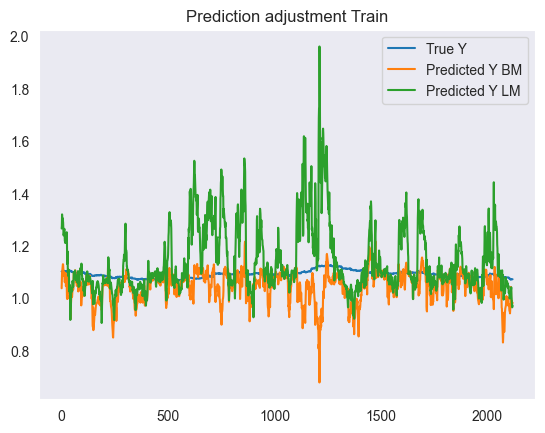

In [44]:
Y_train_predicted_best_model=model1.predict(X_train)
Y_train_predicted_last_model=model.predict(X_train)
Y_train_true=(y_train.reshape(y_train.shape[0],1))
axes=plt.axes()
axes.plot(Y_train_true, label='True Y')
axes.plot(Y_train_predicted_best_model, label='Predicted Y BM')
axes.plot(Y_train_predicted_last_model, label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Train')

10/10 [==============================] - 6s 562ms/step


Text(0.5, 1.0, 'Prediction adjustment Validation')

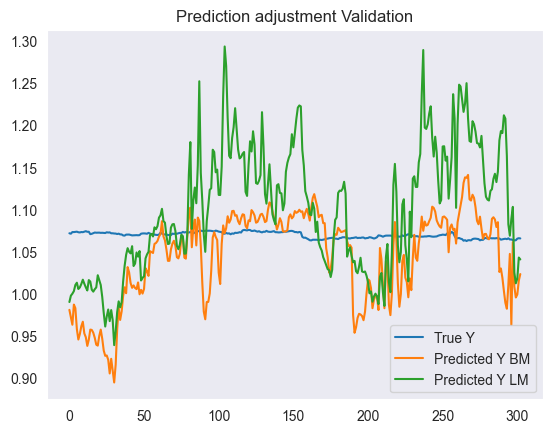

In [45]:
Y_val_predicted_best_model=model1.predict(X_val)
Y_val_predicted_last_model=model.predict(X_val)
Y_val_true=(y_val.reshape(y_val.shape[0],1))
axes=plt.axes()
axes.plot(Y_val_true, label='True Y')
axes.plot(Y_val_predicted_best_model, label='Predicted Y BM')
axes.plot(Y_val_predicted_last_model, label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Validation')

In [46]:
Y_predicted_best_model=model1.predict(X_test)
Y_predicted_last_model=model.predict(X_test)
Y_true=(y_test.reshape(y_test.shape[0],1))

19/19 [==============================] - 11s 600ms/step


Text(0.5, 1.0, 'Prediction adjustment Test')

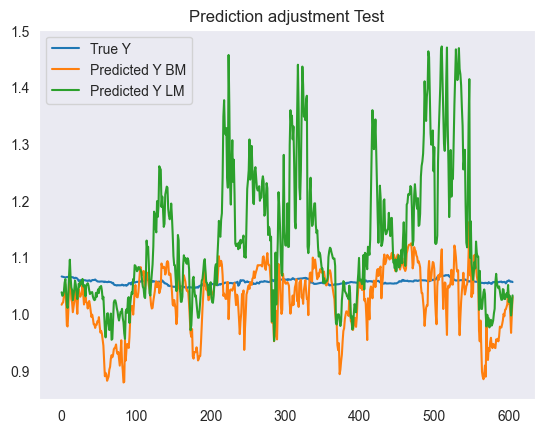

In [47]:
zoom = slice(None) #0,100
axes=plt.axes()
axes.plot(Y_true[zoom], label='True Y')
axes.plot(Y_predicted_best_model[zoom], label='Predicted Y BM')
axes.plot(Y_predicted_last_model[zoom], label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Test')

Text(0.5, 1.0, 'Prediction adjustment Test')

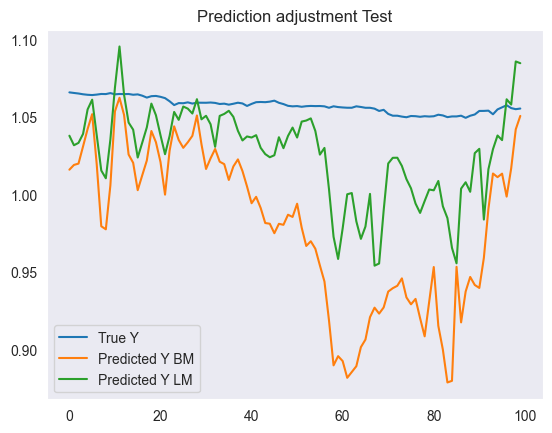

In [48]:
zoom = slice(0,100) #0,100
axes=plt.axes()
axes.plot(Y_true[zoom], label='True Y')
axes.plot(Y_predicted_best_model[zoom], label='Predicted Y BM')
axes.plot(Y_predicted_last_model[zoom], label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Test')